**Import Dataset**

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Upload kaggle.json yang didapatkan dari akun Kaggle
from google.colab import files
files.upload()  # Pilih file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farisghina","key":"a9bf152695d953cf4e5c887ab3662094"}'}

In [3]:
# Buat direktori dan ubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

# Unzip dataset dan hapus file zip
!unzip indonesia-tourism-destination.zip

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 616MB/s]
Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


Dataset yang digunakan dalam proyek ini berasal dari [Kaggle - Indonesia Tourist Destination](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination)

**Data Understanding**

**Data Loading**

In [4]:
tourism = pd.read_csv('tourism_with_id.csv')
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [5]:
rating = pd.read_csv('tourism_rating.csv')
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [6]:
tourism.head(5)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [7]:
rating.head(5)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [8]:
print(f"Number of places in the datasets : {len(tourism.Place_Id.unique())}")
print(f"Category name : ", tourism.Category.unique())

Number of places in the datasets : 437
Category name :  ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']


In [9]:
# Melihat missing value dan duplikasi data pada tabel tourism
print("missing value tourism: ", tourism.isnull().sum())
print("jumlah duplikat tourism: ", tourism.duplicated().sum())

missing value tourism:  Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64
jumlah duplikat tourism:  0


In [10]:
# Melihat missing value dan duplikasi data pada tabel rating
print("missing value rating: ", rating.isnull().sum())
print("jumlah duplikat rating: ", rating.duplicated().sum())

missing value rating:  User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64
jumlah duplikat rating:  79


In [11]:
tourism_all = np.concatenate((
    tourism.Place_Id.unique(),
    rating.Place_Id.unique()
))

tourism_all = np.sort(np.unique(tourism_all))

print(f"Total number of tourism: {len(tourism_all)}")

Total number of tourism: 437


In [12]:
all_tourism_rate = rating
all_tourism_rate

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [13]:
all_tourism = pd.merge(all_tourism_rate, tourism[["Place_Id","Place_Name", "Price", "Description","City","Category", "Coordinate", "Lat", "Long"]],on='Place_Id', how='left')
all_tourism

,User_Id,Place_Id,Place_Ratings,Place_Name,Price,Description,City,Category,Coordinate,Lat,Long
0,1,179,3,Candi Ratu Boko,75000,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416
1,1,344,2,Pantai Marina,3000,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329
2,1,5,5,Atlantis Water Adventure,94000,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
3,1,373,3,Museum Kereta Ambarawa,10000,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602
4,1,101,4,Kampung Wisata Sosro Menduran,0,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151
...,...,...,...,...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,35000,Waterpark Kenjeran Surabaya merupakan wisata k...,Surabaya,Taman Hiburan,"{'lat': -7.247796300000002, 'lng': 112.7998235}",-7.247796,112.799824
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,2000,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Jakarta,Budaya,"{'lat': -6.204630300000001, 'lng': 106.8365324}",-6.204630,106.836532
9997,300,311,3,The Lodge Maribaya,25000,The Lodge Maribaya adalah salah satu tempat wi...,Bandung,Cagar Alam,"{'lat': -6.829411199999999, 'lng': 107.6874666}",-6.829411,107.687467
9998,300,279,4,Masjid Agung Trans Studio Bandung,0,Masjid Agung Trans Studio Bandung (TSB) berdir...,Bandung,Tempat Ibadah,"{'lat': -6.925963500000001, 'lng': 107.6354278}",-6.925963,107.635428


In [14]:
all_tourism['city_category'] = all_tourism[['City','Category']].agg(' '.join,axis=1)
all_tourism

,User_Id,Place_Id,Place_Ratings,Place_Name,Price,Description,City,Category,Coordinate,Lat,Long,city_category
0,1,179,3,Candi Ratu Boko,75000,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,Yogyakarta Budaya
1,1,344,2,Pantai Marina,3000,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,Semarang Bahari
2,1,5,5,Atlantis Water Adventure,94000,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,Jakarta Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,10000,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,Semarang Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,0,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,Yogyakarta Budaya
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,35000,Waterpark Kenjeran Surabaya merupakan wisata k...,Surabaya,Taman Hiburan,"{'lat': -7.247796300000002, 'lng': 112.7998235}",-7.247796,112.799824,Surabaya Taman Hiburan
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,2000,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Jakarta,Budaya,"{'lat': -6.204630300000001, 'lng': 106.8365324}",-6.204630,106.836532,Jakarta Budaya
9997,300,311,3,The Lodge Maribaya,25000,The Lodge Maribaya adalah salah satu tempat wi...,Bandung,Cagar Alam,"{'lat': -6.829411199999999, 'lng': 107.6874666}",-6.829411,107.687467,Bandung Cagar Alam
9998,300,279,4,Masjid Agung Trans Studio Bandung,0,Masjid Agung Trans Studio Bandung (TSB) berdir...,Bandung,Tempat Ibadah,"{'lat': -6.925963500000001, 'lng': 107.6354278}",-6.925963,107.635428,Bandung Tempat Ibadah


In [15]:
print(all_tourism.isnull().sum())
print("jumlah duplikat all_tourism: ", all_tourism.duplicated().sum())

User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
Price            0
Description      0
City             0
Category         0
Coordinate       0
Lat              0
Long             0
city_category    0
dtype: int64
jumlah duplikat all_tourism:  79


In [16]:
preparation= all_tourism.drop_duplicates("Place_Id")
preparation

,User_Id,Place_Id,Place_Ratings,Place_Name,Price,Description,City,Category,Coordinate,Lat,Long,city_category
0,1,179,3,Candi Ratu Boko,75000,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,Yogyakarta Budaya
1,1,344,2,Pantai Marina,3000,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,Semarang Bahari
2,1,5,5,Atlantis Water Adventure,94000,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,Jakarta Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,10000,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,Semarang Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,0,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,Yogyakarta Budaya
...,...,...,...,...,...,...,...,...,...,...,...,...
2008,62,370,1,Benteng Pendem,5000,Benteng Pendem Cilacap (bahasa Belanda: Kustba...,Semarang,Budaya,"{'lat': -7.2706462, 'lng': 110.4103291}",-7.270646,110.410329,Semarang Budaya
2399,74,350,4,Pantai Cipta,5000,Pantai Cipta juga dikenal sebagai Pantai Petik...,Semarang,Bahari,"{'lat': -6.9486402, 'lng': 110.4102923}",-6.948640,110.410292,Semarang Bahari
2448,75,10,2,Pulau Tidung,150000,Pulau Tidung adalah salah satu kelurahan di ke...,Jakarta,Bahari,"{'lat': -5.803205300000001, 'lng': 106.5237907}",-5.803205,106.523791,Jakarta Bahari
2534,78,7,4,Kebun Binatang Ragunan,4000,Kebun Binatang Ragunan adalah sebuah kebun bin...,Jakarta,Cagar Alam,"{'lat': -6.3124593, 'lng': 106.8201865}",-6.312459,106.820187,Jakarta Cagar Alam


In [17]:
place_id = preparation.Place_Id.tolist()
place_name = preparation.Place_Name.tolist()
place_rating = preparation.Place_Ratings.tolist()
place_price = preparation.Price.tolist()
place_category = preparation.Category.tolist()
place_desc = preparation.Description.tolist()
place_city = preparation.City.tolist()
place_coordinate = preparation.Coordinate.tolist()
place_lat = preparation.Lat.tolist()
place_long = preparation.Long.tolist()
city_category = preparation.city_category.tolist()

In [18]:
tourism_new = pd.DataFrame({
    "id":place_id,
    "name":place_name,
    "rating":place_rating,
    "price":place_price,
    "category":place_category,
    "description":place_desc,
    "city":place_city,
    "coordinate":place_coordinate,
    "lat":place_lat,
    "long":place_long,
    "city_category":city_category
})

tourism_new

,id,name,rating,price,category,description,city,coordinate,lat,long,city_category
0,179,Candi Ratu Boko,3,75000,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,Yogyakarta Budaya
1,344,Pantai Marina,2,3000,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,Semarang Bahari
2,5,Atlantis Water Adventure,5,94000,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,Jakarta Taman Hiburan
3,373,Museum Kereta Ambarawa,3,10000,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,Semarang Budaya
4,101,Kampung Wisata Sosro Menduran,4,0,Budaya,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,Yogyakarta Budaya
...,...,...,...,...,...,...,...,...,...,...,...
432,370,Benteng Pendem,1,5000,Budaya,Benteng Pendem Cilacap (bahasa Belanda: Kustba...,Semarang,"{'lat': -7.2706462, 'lng': 110.4103291}",-7.270646,110.410329,Semarang Budaya
433,350,Pantai Cipta,4,5000,Bahari,Pantai Cipta juga dikenal sebagai Pantai Petik...,Semarang,"{'lat': -6.9486402, 'lng': 110.4102923}",-6.948640,110.410292,Semarang Bahari
434,10,Pulau Tidung,2,150000,Bahari,Pulau Tidung adalah salah satu kelurahan di ke...,Jakarta,"{'lat': -5.803205300000001, 'lng': 106.5237907}",-5.803205,106.523791,Jakarta Bahari
435,7,Kebun Binatang Ragunan,4,4000,Cagar Alam,Kebun Binatang Ragunan adalah sebuah kebun bin...,Jakarta,"{'lat': -6.3124593, 'lng': 106.8201865}",-6.312459,106.820187,Jakarta Cagar Alam


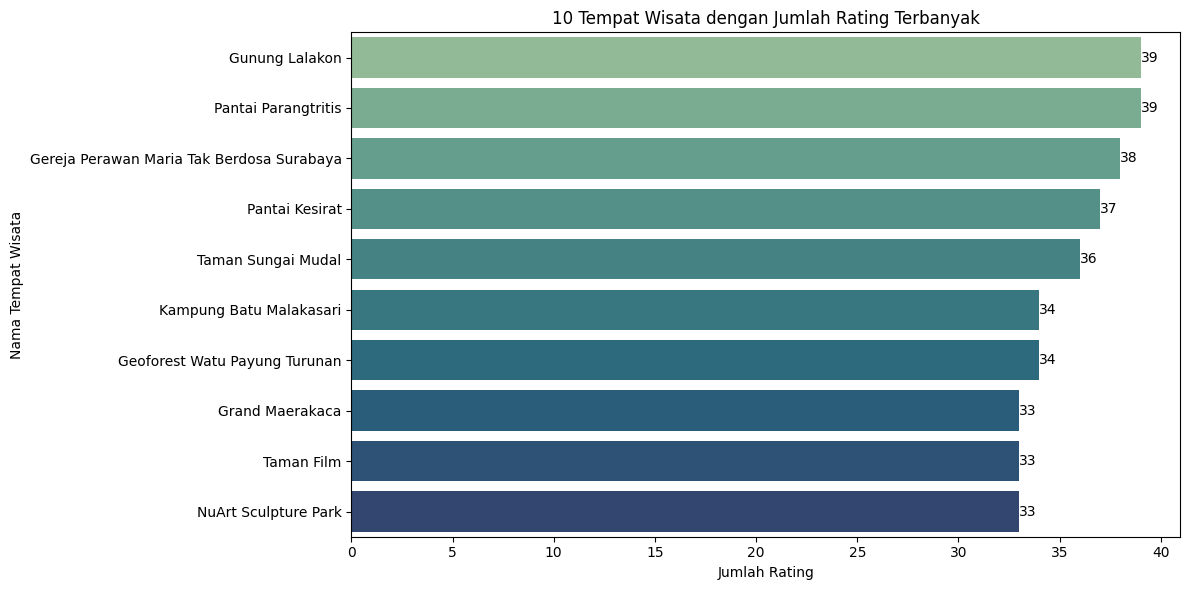

In [19]:
rating_counts = rating['Place_Id'].value_counts().head(10)

# Gabungkan dengan tourism
top_place = tourism_new[tourism_new['id'].isin(rating_counts.index)]
top_place = top_place.set_index('id').loc[rating_counts.index]
top_place['rating_count'] = rating_counts.values

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_place['rating_count'], y=top_place['name'], palette='crest')
plt.title('10 Tempat Wisata dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Nama Tempat Wisata')
for i, count in enumerate(top_place['rating_count']):
    plt.text(count + 0, i, str(count), va='center')
plt.tight_layout()
plt.show()

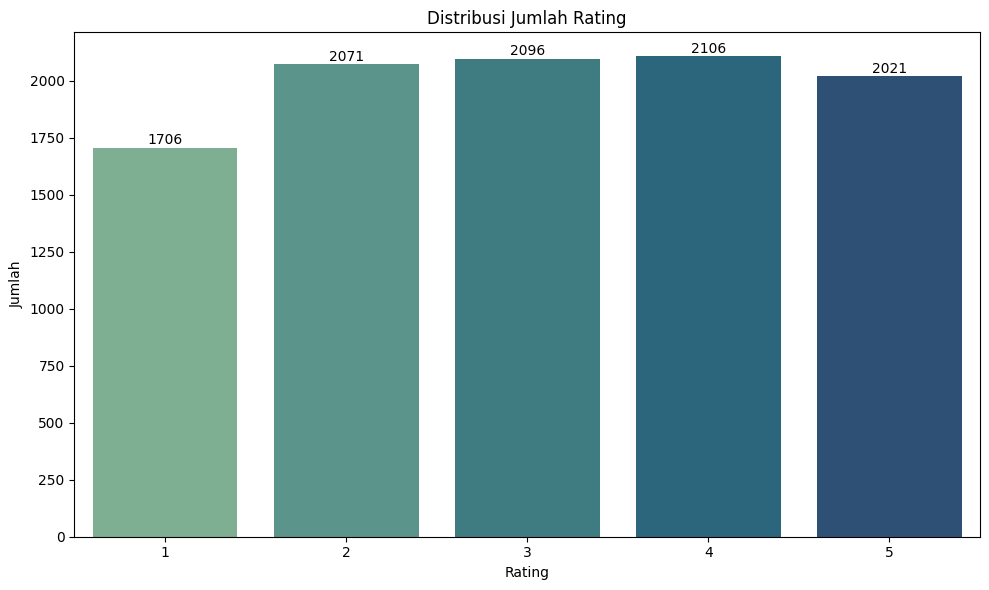

In [20]:
rating_counts = rating['Place_Ratings'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=rating_counts.index.astype(str), y=rating_counts.values, palette='crest')
plt.title('Distribusi Jumlah Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
for i, count in enumerate(rating_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

**Content Based Filtering**

In [21]:
data = tourism_new
data.sample(5)

,id,name,rating,price,category,description,city,coordinate,lat,long,city_category
201,90,Kampung Wisata Taman Sari,5,5000,Taman Hiburan,Taman Sari Yogyakarta atau Taman Sari Keraton ...,Yogyakarta,"{'lat': -7.8100673, 'lng': 110.3594581}",-7.810067,110.359458,Yogyakarta Taman Hiburan
137,359,Taman Bunga Celosia,2,25000,Cagar Alam,Wisata Semarang menawarkan berbagai tempat wis...,Semarang,"{'lat': -7.225504099999998, 'lng': 110.3463166}",-7.225504,110.346317,Semarang Cagar Alam
102,97,Monumen Yogya Kembali,2,15000,Budaya,Museum Monumen Yogya Kembali (bahasa Jawa: ꦩꦺꦴ...,Yogyakarta,"{'lat': -7.7495904, 'lng': 110.3696068}",-7.749590,110.369607,Yogyakarta Budaya
246,325,Saung Angklung Mang Udjo,3,75000,Budaya,Saung Angklung Udjo (SAU) adalah suatu tempat ...,Bandung,"{'lat': -6.897136199999999, 'lng': 107.6558466}",-6.897136,107.655847,Bandung Budaya
86,348,Pura Giri Natha,5,20000,Budaya,Awal berdirinya Pura Agung Giri Natha tidak te...,Semarang,"{'lat': -6.998475900000001, 'lng': 110.4106468}",-6.998476,110.410647,Semarang Budaya


**TF-IDF**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(data['city_category'])

# Mapping array dari fitur index integer ke fitur nama
print("Features Name: ", list(tf.vocabulary_.keys()))

Features Name:  ['yogyakarta', 'budaya', 'semarang', 'bahari', 'jakarta', 'taman', 'hiburan', 'bandung', 'cagar', 'alam', 'surabaya', 'pusat', 'perbelanjaan', 'tempat', 'ibadah']


In [23]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['city_category'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(437, 15)

In [24]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.69559204],
        [0.        , 0.72824058, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.5360408 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.7724966 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.55900007, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.57127819, 0.        ,
         0.58930677]])

In [25]:
# Membuat dataframe untuk melihat tf-idf matrix

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=list(tf.vocabulary_.keys()),
    index=data.name
).sample(22, axis=1,replace=True).sample(10, axis=0)

,taman,semarang,pusat,ibadah,hiburan,ibadah,budaya,budaya,cagar,perbelanjaan,...,alam,bandung,cagar,taman,cagar,jakarta,bahari,bahari,bandung,surabaya
name,,,,,,,,,,,,,,,,,,,,,
Masjid Pusdai,0.000000,0.355383,0.00000,0.000000,0.660947,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
Museum Konferensi Asia Afrika,0.000000,0.698125,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.715975,0.715975,0.000000,0.0
Museum Macan (Modern and Contemporary Art in Nusantara),0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.752306,0.0,0.000000,0.0,0.0,0.658813,0.658813,0.752306,0.0
Museum Nasional,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.752306,0.0,0.000000,0.0,0.0,0.658813,0.658813,0.752306,0.0
Kampung Batu Malakasari,0.569871,0.592025,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.569871,...,0.0,0.000000,0.0,0.569871,0.0,0.0,0.000000,0.000000,0.000000,0.0
Pantai Ngobaran,0.000000,0.000000,0.00000,0.571801,0.000000,0.571801,0.820392,0.820392,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
Taman Pelangi,0.486832,0.000000,0.72525,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.486832,...,0.0,0.000000,0.0,0.486832,0.0,0.0,0.000000,0.000000,0.000000,0.0
Alun Alun Selatan Yogyakarta,0.571278,0.000000,0.00000,0.589307,0.000000,0.589307,0.000000,0.000000,0.0,0.571278,...,0.0,0.000000,0.0,0.571278,0.0,0.0,0.000000,0.000000,0.000000,0.0
Masjid Daarut Tauhiid Bandung,0.000000,0.355383,0.00000,0.000000,0.660947,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


**Cosine Similarity**

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4099171 ],
       [0.        , 1.        , 0.        , ..., 0.56256337, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.41413775, 0.39938865,
        0.61245683],
       ...,
       [0.        , 0.56256337, 0.41413775, ..., 1.        , 0.38888769,
        0.        ],
       [0.        , 0.        , 0.39938865, ..., 0.38888769, 1.        ,
        0.        ],
       [0.4099171 , 0.        , 0.61245683, ..., 0.        , 0.        ,
        1.        ]])

In [27]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama wisata
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


name,Puncak Gunung Api Purba - Nglanggeran,Tektona Waterpark,Hutan Mangrove Kulon Progo,Museum Kesehatan Dr. Adhyatma,Pantai Krakal
name,,,,,
Pantai Wediombo,0.313912,0.000000,1.000000,0.000000,1.000000
Pantai Timang,0.313912,0.000000,1.000000,0.000000,1.000000
Taman Kasmaran,0.000000,0.574201,0.000000,0.000000,0.000000
Museum Pendidikan Nasional,0.000000,0.413308,0.000000,0.416500,0.000000
Roemah Seni Sarasvati,0.000000,0.413308,0.000000,0.416500,0.000000
Gembira Loka Zoo,1.000000,0.000000,0.313912,0.000000,0.313912
Sea World,0.000000,0.610949,0.000000,0.000000,0.000000
Museum Konferensi Asia Afrika,0.000000,0.413308,0.000000,0.416500,0.000000
Green Village Gedangsari,0.323522,0.651110,0.336966,0.000000,0.336966


**Mendapatkan Rekomendasi**

In [28]:
from os import name
def recommendations(input_item=None, similarity_data=cosine_sim_df, items=data[['name', 'rating', 'price', 'category','description','city', 'coordinate', 'lat', 'long']], k=5, price_range=None):
    """
    Provides recommendations based on place name, city name, or price.

    Args:
        input_item (str or float or int, optional): The place name, city name, or a price for filtering. Defaults to None.
        similarity_data (DataFrame): The cosine similarity matrix.
        items (DataFrame): DataFrame containing place details.
        k (int): The number of recommendations to return.
        price_range (tuple, optional): A tuple (min_price, max_price) to filter recommendations by price. This parameter overrides input_item if both are provided.

    Returns:
        DataFrame or str: A DataFrame of recommended places or an error message.
    """
    filtered_items = items.copy()

    if price_range:
        min_price, max_price = price_range
        filtered_items = filtered_items[(filtered_items['price'] >= min_price) & (filtered_items['price'] <= max_price)]
        if filtered_items.empty:
            return "Tidak ada tempat wisata yang ditemukan dalam rentang harga tersebut."

    if input_item:
        if isinstance(input_item, (int, float)):
            # If input is a number, treat it as a price and search within a range
            print(f"Input harga terdeteksi: {input_item}. Mencari tempat wisata di sekitar harga ini.")
            # Define a price range around the input price (e.g., +/- 20%)
            price_range = (input_item * 0.8, input_item * 1.2)
            min_price, max_price = price_range
            filtered_items = items[(items['price'] >= min_price) & (items['price'] <= max_price)]
            if filtered_items.empty:
                return f"Tidak ada tempat wisata ditemukan di sekitar harga {input_item}."
            elif len(filtered_items) > k:
                return filtered_items.sample(k)
            else:
                return filtered_items

        elif input_item in filtered_items['name'].values:
            # If it's a place name, get recommendations based on similarity to that place
            # Ensure the input_item is in the index of the similarity_data after price filtering
            if input_item not in similarity_data.index:
                 return "Input tempat wisata tidak ditemukan setelah filter harga."

            # Filter similarity data based on the places remaining after price filtering
            valid_indices = filtered_items['name'].tolist()
            similarity_data_filtered = similarity_data.loc[valid_indices, valid_indices]

            if input_item not in similarity_data_filtered.columns:
                 return "Input tempat wisata tidak ditemukan dalam data similarity setelah filter harga."

            index = similarity_data_filtered.loc[:,input_item].to_numpy().argpartition(
                range(-1, -k, -1))
            closest = similarity_data_filtered.columns[index[-1:-(k+2):-1]]
            # Ensure the input item is not included in the recommendations
            closest = closest.drop(input_item, errors='ignore')
            # Merge with the original items DataFrame to get full details, ensuring correct join
            recommended_df = pd.DataFrame(closest, columns=['name']).merge(items, on='name', how='left')
            return recommended_df.head(k)

        elif input_item in filtered_items['city'].values:
            # If it's a city name, filter items by city and return a sample
            city_items = filtered_items[filtered_items['city'] == input_item]
            if city_items.empty:
                return f"Tidak ada tempat wisata ditemukan di {input_item} dalam rentang harga tersebut."

            if len(city_items) > k:
                return city_items.sample(k)
            else:
                return city_items
        else:
            # If input_item is provided but not a valid place or city name or price
             return "Input tidak ditemukan. Mohon masukkan nama tempat wisata, nama kota, atau harga yang valid."
    elif price_range:
        # If only price_range is provided, return items filtered by price
        # Since filtered_items is already filtered by price_range if it was provided,
        # we can just return a sample from filtered_items
        if filtered_items.empty:
            return "Tidak ada tempat wisata yang ditemukan dalam rentang harga tersebut."
        elif len(filtered_items) > k:
            return filtered_items.sample(k)
        else:
            return filtered_items
    else:
        return "Mohon masukkan nama tempat wisata, nama kota, atau rentang harga untuk rekomendasi."

Mencoba memasukkan nama tempat wisata dan keluar hasil dengan nama tempat wisata yang sama

In [29]:
recommendations('Museum Pos Indonesia')

,name,rating,price,category,description,city,coordinate,lat,long
0,Bandros City Tour,3,40000,Budaya,Bandros atau Bus Wisata Bandung adalah bus wis...,Bandung,"{'lat': -6.922081599999999, 'lng': 107.6073182}",-6.922082,107.607318
1,Jalan Braga,3,0,Budaya,Jalan Braga adalah nama sebuah jalan utama di ...,Bandung,"{'lat': -6.9150534, 'lng': 107.6089842}",-6.915053,107.608984
2,Amazing Art World,3,75000,Budaya,"Amazing Art World Bandung, sebuah objek wisata...",Bandung,"{'lat': -6.8516591, 'lng': 107.5955534}",-6.851659,107.595553
3,Taman Budaya Jawa Barat,3,0,Budaya,Taman Budaya Jawa Barat (TBJB) didirikan pada ...,Bandung,"{'lat': -6.870099, 'lng': 107.6164386}",-6.870099,107.616439
4,Museum Mandala Wangsit Siliwangi,5,0,Budaya,Museum Wangsit Mandala Siliwangi adalah museum...,Bandung,"{'lat': -6.9173405, 'lng': 107.6112627}",-6.917340,107.611263


In [30]:
recommendations('Yogyakarta')

,name,rating,price,category,description,city,coordinate,lat,long
76,Desa Wisata Gamplong,3,10000,Taman Hiburan,Desa Wisata Gamplong adalah desa wisata keraji...,Yogyakarta,"{'lat': -7.805523199999997, 'lng': 110.2374676}",-7.805523,110.237468
88,Museum Benteng Vredeburg Yogyakarta,3,3000,Budaya,Museum Benteng Vredeburg (bahasa Jawa: ꦩꦸꦱꦶꦪꦸꦩ...,Yogyakarta,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304
384,Pantai Baron,5,10000,Bahari,Pantai Baron adalah salah satu objek wisata be...,Yogyakarta,"{'lat': -8.1288246, 'lng': 110.5487763}",-8.128825,110.548776
70,Watu Lumbung,4,5000,Cagar Alam,Letak Kampung Edukasi Watu Lumbung yang berada...,Yogyakarta,"{'lat': -7.992437900000001, 'lng': 110.317778}",-7.992438,110.317778
103,Jogja Exotarium,2,20000,Taman Hiburan,"Di Yogyakarta, tepatnya di Sleman, ada satu te...",Yogyakarta,"{'lat': -7.7280356, 'lng': 110.3591712}",-7.728036,110.359171


In [31]:
recommendations(23456)

Input harga terdeteksi: 23456. Mencari tempat wisata di sekitar harga ini.


,name,rating,price,category,description,city,coordinate,lat,long
159,Wisata Alam Mangrove Angke,3,25000,Cagar Alam,Jangan anggap di Jakarta tidak ada wisata alam...,Jakarta,"{'lat': -6.105334, 'lng': 106.735584}",-6.105334,106.735584
292,Rainbow Garden,2,20000,Cagar Alam,Rainbow Garden Harapan Indah salah satu taman ...,Bandung,"{'lat': -6.8179514, 'lng': 107.618914}",-6.817951,107.618914
218,Taman Impian Jaya Ancol,5,25000,Taman Hiburan,Taman Impian Jaya Ancol merupakan sebuah objek...,Jakarta,"{'lat': -6.117333200000001, 'lng': 106.8579951}",-6.117333,106.857995
167,Curug Cipanas,3,20000,Cagar Alam,Siapa bilang berendam air panas harus merogoh ...,Bandung,"{'lat': -6.7991958, 'lng': 107.5922088}",-6.799196,107.592209
422,Bukit Moko,3,25000,Cagar Alam,Bandung sebagai destinasi wisata tak pernah ad...,Bandung,"{'lat': -6.8422202, 'lng': 107.6767988}",-6.842220,107.676799


**Collaborative Filtering**

In [32]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

**Data Preparation**

In [33]:
df = rating
df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [34]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['User_Id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [35]:
# Mengubah userID menjadi list tanpa nilai yang sama
place_ids = df['Place_Id'].unique().tolist()
print('nama tempat wisata: ', place_ids)

# Melakukan encoding userID
nama_to_nama_encoded = {x: i for i, x in enumerate(place_ids)}
print('encoded nama tempat wisata : ', nama_to_nama_encoded)

# Melakukan proses encoding angka ke ke userID
nama_encoded_to_nama = {i: x for i, x in enumerate(place_ids)}
print('encoded angka ke cluster: ', nama_encoded_to_nama)

nama tempat wisata:  [179, 344, 5, 373, 101, 312, 258, 20, 154, 393, 103, 208, 89, 405, 41, 336, 67, 292, 222, 76, 428, 15, 246, 265, 21, 328, 307, 302, 48, 147, 2, 322, 23, 85, 371, 78, 111, 107, 185, 413, 389, 437, 105, 176, 407, 281, 167, 384, 426, 390, 367, 166, 18, 321, 262, 223, 17, 319, 310, 421, 202, 283, 250, 118, 54, 70, 33, 227, 86, 249, 131, 382, 193, 104, 24, 128, 134, 228, 237, 100, 198, 50, 376, 268, 242, 82, 348, 409, 88, 4, 377, 43, 91, 44, 14, 406, 383, 229, 290, 294, 309, 74, 97, 138, 436, 395, 300, 68, 55, 434, 9, 151, 61, 159, 397, 391, 301, 143, 27, 190, 346, 381, 368, 433, 420, 335, 115, 334, 219, 178, 266, 92, 64, 102, 257, 243, 116, 359, 121, 385, 398, 119, 298, 410, 224, 379, 255, 269, 213, 126, 192, 183, 129, 303, 296, 99, 148, 13, 247, 31, 77, 158, 306, 98, 235, 45, 173, 275, 25, 130, 164, 267, 56, 30, 238, 402, 196, 417, 304, 206, 211, 28, 264, 403, 253, 331, 188, 416, 378, 233, 95, 204, 225, 341, 145, 36, 168, 12, 280, 236, 42, 90, 75, 63, 205, 234, 284, 2

pada kode diatas adalah untuk mengubah ID user dan movieId menjadi angka untuk dapat diproses oleh model.

In [36]:
# Mapping userID ke dataframe user
df['user'] = df['User_Id'].map(user_to_user_encoded)

# Mapping movieId ke dataframe judul
df['place'] = df['Place_Id'].map(nama_to_nama_encoded)

Tahap tersebut untuk melakukan mapping atau mengganti nilai userID di DataFrame df menjadi nilai numerik (encoded).
Dengan fungsi `.map()`.

In [37]:
# Mendapatkan jumlah user
num_user = len(user_to_user_encoded)
print(num_user)

num_place = len(nama_to_nama_encoded)
print(num_place)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(df['Place_Ratings'])

print('Number of User: {}, Number of Place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_user, num_place, min_rating, max_rating
))

300
437
Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


**Data Splitting**

In [38]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283
...,...,...,...,...,...
5734,173,402,5.0,172,175
5191,157,85,4.0,156,33
5390,163,18,3.0,162,52
860,28,416,4.0,27,187


In [39]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[187 262]
 [141  83]
 [ 53  10]
 ...
 [162  52]
 [ 27 187]
 [218   6]] [0.5  0.25 0.5  ... 0.5  0.75 0.25]


In [40]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_user, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_user = num_user
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_user, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings movie
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_track_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_track_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid


In [41]:
model = RecommenderNet(num_user, num_place, 100) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [42]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6953 - root_mean_squared_error: 0.3458 - val_loss: 0.6960 - val_root_mean_squared_error: 0.3469
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6877 - root_mean_squared_error: 0.3390 - val_loss: 0.6969 - val_root_mean_squared_error: 0.3474
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6835 - root_mean_squared_error: 0.3379 - val_loss: 0.6969 - val_root_mean_squared_error: 0.3475
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6783 - root_mean_squared_error: 0.3363 - val_loss: 0.6971 - val_root_mean_squared_error: 0.3476
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6759 - root_mean_squared_error: 0.3363 - val_loss: 0.6991 - val_root_mean_squared_error: 0.3489
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6759 - root_mean_squared_error: 0.3312 - val_loss: 0.6991 - val_root_mean_squared_error: 0.3489
Epoch 7/100
1000/1000 ━━━━━━━━━━━━

**Evaluation**

**Visualisasi Metrik**

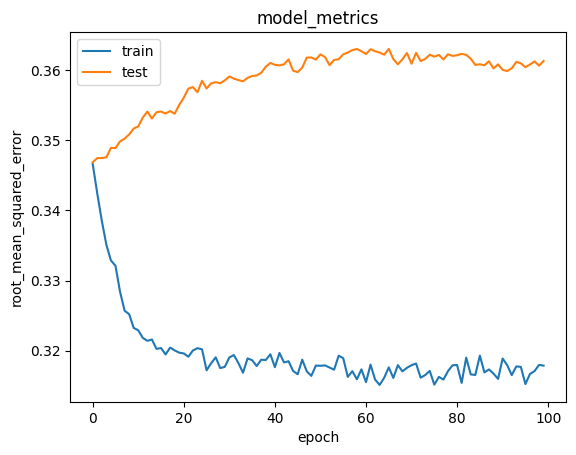

In [43]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
tourism_df = tourism_new
df = pd.read_csv('tourism_rating.csv')

# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
movie_watched_by_user = df[df.User_Id == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = tourism_df[~tourism_df['id'].isin(movie_watched_by_user.Place_Id.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(nama_to_nama_encoded.keys()))
)

movie_not_watched = [[nama_to_nama_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [45]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_tourism_ids = [
    nama_encoded_to_nama.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Tempat wisata dengan rating tinggi dari user')
print('----' * 8)

top_tourism_user = (
    movie_watched_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

movie_df_rows = tourism_df[tourism_df['id'].isin(top_tourism_user)]
for row in movie_df_rows.itertuples():
    print(row.name, ':', row.category, ':', row.rating, ':', row.city)

print('----' * 8)
print('Top 10 Rekomendasi Tempat Wisata')
print('----' * 8)

recommended_movie = tourism_df[tourism_df['id'].isin(recommended_tourism_ids)]
for row in recommended_movie.itertuples():
    print(row.name, ':', row.category, ':', row.rating, ':', row.city)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Showing recommendations for users: 191
Tempat wisata dengan rating tinggi dari user
--------------------------------
Glamping Lakeside Rancabali : Taman Hiburan : 3 : Bandung
Taman Bunga Cihideung : Cagar Alam : 3 : Bandung
Goa Pindul : Cagar Alam : 3 : Yogyakarta
Lembang Park & Zoo : Cagar Alam : 3 : Bandung
Hutan Pinus Kayon : Cagar Alam : 3 : Semarang
--------------------------------
Top 10 Rekomendasi Tempat Wisata
--------------------------------
Geoforest Watu Payung Turunan : Cagar Alam : 2 : Yogyakarta
Kampung Korea Bandung : Budaya : 5 : Bandung
Selasar Sunaryo Art Space : Taman Hiburan : 4 : Bandung
Keraton Surabaya : Budaya : 4 : Surabaya
Wisata Batu Kuda : Cagar Alam : 4 : Bandung
Ciwangun Indah Camp Official : Cagar Alam : 2 : Bandung
Curug Batu Templek : Cagar Alam : 2 : Bandung
Pantai Baron : Bahari : 5 : Yogyakarta
Teras Cikapundung BBWS : Taman Hiburan : 5 : Bandung
The World Landmarks - Merapi Park Yogyakarta : Taman Hiburan : 5

## Save the content-based filtering data

### Subtask:
Save the necessary data structures for content-based filtering: the TF-IDF vectorizer, the cosine similarity matrix, and the `tourism_new` dataframe containing place details.

**Reasoning**:
Save the TF-IDF vectorizer, cosine similarity matrix, and tourism data to files for later use.

In [47]:
import pickle
import joblib

# Save the TF-IDF vectorizer using joblib
joblib.dump(tf, 'tfidf_vectorizer.pkl')

# Save the cosine similarity matrix
with open('cosine_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Save the tourism_new DataFrame
tourism_new.to_csv('tourism_data.csv', index=False)

print("Content-based filtering data saved successfully.")

TypeError: cannot pickle 'module' object

**Reasoning**:
The TF-IDF vectorizer object `tf` cannot be directly pickled because it's a module object. I will try saving the trained vectorizer object instead of the module. If that still fails, I will try using `joblib` which is often better for scikit-learn objects.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import joblib

# Re-initialize and fit the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['city_category'])

# Calculate cosine similarity again
cosine_sim = cosine_similarity(tfidf_matrix)

# Save the fitted TF-IDF vectorizer using joblib
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the cosine similarity matrix
with open('cosine_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Save the tourism_new DataFrame
tourism_new.to_csv('tourism_data.csv', index=False)

print("Content-based filtering data saved successfully.")

Content-based filtering data saved successfully.


In [ ]:
!pip install tensorflowjs

In [ ]:
# Menyimpan model dalam format SavedModel
import os
import tensorflow as tf

save_path = os.path.join("models/SavedModel/")
tf.saved_model.save(model, save_path)

In [ ]:
# Menyimpan model dalam format TF-Lite
import os
import tensorflow as tf
os.makedirs('tflite_model', exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("tflite_model/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

# class_names = list(train_generator.class_indices.keys())

# # Simpan nama kelas ke dalam file label.txt
# with open("tflite_model/label.txt", "w") as f:
#     for class_name in class_names:
#         f.write(class_name + "\n")

## Save the collaborative filtering data

### Subtask:
Save the trained collaborative filtering model and the user and place encoding dictionaries (`user_to_user_encoded`, `nama_to_nama_encoded`, `user_encoded_to_user`, `nama_encoded_to_nama`) to files.

**Reasoning**:
Save the trained model and encoding dictionaries for later use in the API.

In [ ]:
import pickle
import tensorflow as tf

# Save the trained collaborative filtering model
model.save('collaborative_filtering_model.h5')

# Save the encoding dictionaries
with open('user_to_user_encoded.pkl', 'wb') as f:
    pickle.dump(user_to_user_encoded, f)

with open('nama_to_nama_encoded.pkl', 'wb') as f:
    pickle.dump(nama_to_nama_encoded, f)

with open('user_encoded_to_user.pkl', 'wb') as f:
    pickle.dump(user_encoded_to_user, f)

with open('nama_encoded_to_nama.pkl', 'wb') as f:
    pickle.dump(nama_encoded_to_nama, f)

print("Collaborative filtering data saved successfully.")

In [ ]:
import tensorflow as tf

# Konversi dari model .h5 langsung ke .tflite
converter = tf.lite.TFLiteConverter.from_keras_model_file('collaborative_filtering_model.h5')  # untuk TensorFlow < 2.13
# Jika kamu menggunakan TensorFlow ≥ 2.13, gunakan:
# model = tf.keras.models.load_model('model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('collaborative_filtering_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model .tflite berhasil dibuat dari model.h5")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import joblib

# Re-initialize and fit the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['city_category'])

# Calculate cosine similarity again
cosine_sim = cosine_similarity(tfidf_matrix)

# Save the fitted TF-IDF vectorizer using joblib
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the cosine similarity matrix
with open('cosine_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Save the tourism_new DataFrame
tourism_new.to_csv('tourism_data.csv', index=False)